In [28]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit

from pcygni_profile import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    plt.rcParams['pcolor.shading'] = 'nearest'
    

def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

def planck(wav, T, N, z_pec=0.): #blackbody
    wav = wav*(1+z_pec)
    a = 2.0*h*pi*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5)*(math.e**b - 1.0) )
    return N*intensity

def lum_dist(p, psig, beta, dbeta, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    theta = 2*np.sqrt(p[1]*10**(7)/np.pi)
    dtheta = 1/np.sqrt(p[1])*np.sqrt(10**(7)/np.pi)*psig[1]

    v = beta*c/2; dv = dbeta*c/2 #factor of 2
    t = (n_days-dt) * (3600*24)
    r = v*t; dr = dv*t 
    
    D = r/theta*2# factor of 2 
    dD = ( (r/theta**2*2*dtheta)**2 + (dr/theta*2)**2 )**(1/2)

    D_mpc = D*(3.2408e-23)
    dD_mpc = dD*(3.2408e-23)
    
    return D_mpc, dD_mpc

n_days = [1.427, 2.417, 3.413, 4.403]

In [14]:
reset_plt(18,25)
path = '.\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)
x = np.loadtxt(path+'/'+files[2])
exc_reg = (~((x[:,0] > 13100) & (x[:,0] < 14360))) & (~((x[:,0] > 17550) & (x[:,0] < 19000))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9940) & (x[:,0] < 10300))) & \
          (x[:,0] > 3400) & (x[:,0] < 22500) & \
          (~((x[:,0] > 3000) & (x[:,0] < 4500))) #& (~((x[:,0] > 7000) & (x[:,0] < 8500))) #sr absorbtion feature


In [195]:
def lum_dist(p, psig, beta, dbeta, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    theta = 2*np.sqrt(p[1]*10**(7)/np.pi)
    dtheta = 1/np.sqrt(p[1])*np.sqrt(10**(7)/np.pi)*psig[1]

    v = beta*c/2; dv = dbeta*c/2 #factor of 2
    t = (n_days-dt) * (3600*24)
    r = v*t; dr = dv*t 
    
    D = r/theta*2# factor of 2 
    dD = ( (r/theta**2*2*dtheta)**2 + (dr/theta*2)**2 )**(1/2)

    D_mpc = D*(3.2408e-23)
    dD_mpc = dD*(3.2408e-23)
    
    return D_mpc, dD_mpc

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, v1=0.2, ve=0.2, t_0 = 120960): 
    prof_calc = PcygniCalculator(t=t_0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=v1 *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    #prof_calc._lam_min=6e-5
    #prof_calc._lam_max=13e-5
    #prof_calc._nu_min = csts.c.cgs.value / prof_calc._lam_max
    #prof_calc._nu_max = csts.c.cgs.value / prof_calc._lam_min
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 ) #
    #print(v_out, v_phot, tau)
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)
    y_inter = inter(wl)
    
    return y_inter

def gaussian(wav,amp1,cen,sig):
    return amp1*np.exp(-(wav-cen)**2/(2*sig**2))
    
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1.5,#amp1 = 2, cen1=15500, sig1=250, 
                    ve=0.2, lam=10506.3653, z_pec=0.): #blackbody
    wav = wav*(1+z_pec)
    a = 2.0*h*pi*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5)*(math.e**b - 1.0) )
    
    correction = p_cygni_line_corr(wav, v_out, v_phot, tau, lam, v1=0.22, ve=ve, t_0=24*3600*3.41)
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    # Gaussians
    #gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = models.Gaussian1D.evaluate(t, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity #+gau1

In [81]:
120960, 24*3600*3.41

(120960, 294624.0)

def p_cygni_line_corr(wl, vmax, vphot, tauref, v1, ve, lam0, t0=120960):
    prof_calc = pcygni_profile.PcygniCalculator(t=t0 * u.s, vmax=vmax * c.c,
                                 vphot=vphot * c.c, tauref=tauref, vref=vref * c.c, ve=ve * c.c,
                                 lam0=lam0 * u.AA)

    x, pcyg = prof_calc.calc_profile_Flam(npoints=25, mode="both")
    f = interpolate.interp1d(x, pcyg, bounds_error=False, fill_value=1)
    return f(wl)

def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, lam=10506.3653, v1=0.2, v2=0.2, z_pec=0.): #blackbody
    wav = wav*(1+z_pec)
    a = 2.0*h*pi*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5)*(math.e**b - 1.0) )
    
    correction = p_cygni_line_corr(wav[(wav>7e-7) & (wav<13e-7)], v_out, v_phot, tau, v1, v2, lam)
    
    intensity[(wav>7e-7) & (wav<13e-7)] = intensity[(wav>7e-7) & (wav<13e-7)]*correction
    return N*intensity

### Here is P Cygni

In [184]:
### day 3
{"unique_symbols": {"amp2": 0.7067328715106156, "infty": Infinity, "NAN": NaN, "R": 1538586048905204.2, 
"None": null, "cen2": 20168.609301055043, "t0": 298800, "Inf": Infinity, "pi": 3.141592653589793, 
        "tauref3": 0.0, "little_endian": true, "True": true, "inf": Infinity, "occult1": 0, 
        "vmax": 0.22920973934804734, "sig1": 459.9664870756013, "newaxis": null, "sig2": 1086.8596043843086, 
        "e": 2.718281828459045, "T": 3338.394827851165, "amp1": 0.801562103297056, "False": false, 
        "cen1": 15502.133284243584, "vref": 0, "beta": 0.20049632201057593, "tauref2": 3.075304530606423, 
        "tauref1": 0.43556601472943823, "nan": NaN, "occult2": 4.99478650876358, "ve": 0.06193507906425483}, 
 "params": [["T", 3338.394827851165, true, null, 2500, 7500, null, null, null, 3200, null], 
            ["R", 1538586048905204.2, true, null, 100000000000000.0, 1e+16, null, null, null, 2200000000000000.0, null], 
            ["beta", 0.20049632201057593, true, null, 0, 1, null, null, null, 0.24, null], 
            ["t0", 298800, false, null, -Infinity, Infinity, null, null, null, 298800, null], 
            ["vmax", 0.22920973934804734, true, null, 0, 1, null, null, null, 0.26, null], 
            ["tauref1", 0.43556601472943823, true, null, 0, 500, null, null, null, 0, null], 
            ["tauref2", 3.075304530606423, true, null, 0, 10, null, null, null, 1, null], 
            ["tauref3", 0.0, false, null, 0, 10, null, null, null, 0.0, null], 
            ["vref", 0, false, null, 0, 1, null, null, null, 0, null], 
            ["ve", 0.06193507906425483, true, null, 0, 1, null, null, null, 0.2, null], 
            ["occult1", 0, false, null, 0, 10, null, null, null, 0, null], 
            ["occult2", 4.99478650876358, true, null, 0, 10, null, null, null, 5, null], 
            ["amp1", 0.801562103297056, true, null, 0.01, 5, null, null, null, 0.5, null], 
            ["amp2", 0.7067328715106156, true, null, 0.01, 5, null, null, null, 0.5, null], 
            ["cen1", 15502.133284243584, true, null, 14000, 17000, null, null, null, 15500, null], 
            ["cen2", 20168.609301055043, true, null, 19000, 22000, null, null, null, 20300, null], 
            ["sig1", 459.9664870756013, true, null, 100, 3000, null, null, null, 600, null], 
            ["sig2", 1086.8596043843086, true, null, 100, 3000, null, null, null, 600, null]]}

NameError: name 'Infinity' is not defined

In [221]:
x = np.loadtxt(path+'/'+files[2])
exc_reg_2 = (~((x[:,0] > 12700) & (x[:,0] < 14360))) & (~((x[:,0] > 17600) & (x[:,0] < 19000))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (x[:,0] > 3300) & (x[:,0] < 22700)

In [222]:
#gau2 = models.Gaussian1D.evaluate(x[:,0], 1e-17*0.7, 20168, 1086)
#gau1 = models.Gaussian1D.evaluate(x[:,0], 1e-17*0.8, 15502, 460)


In [223]:
from astropy.modeling import models

p, cov = curve_fit(planck_with_mod, x[:,0][exc_reg_2]*1e-10,x[:,1][exc_reg_2],#-gau1[exc_reg_2]-gau2[exc_reg_2], 
    sigma = x[:,3][exc_reg_2], p0 = [3111, 2*10**(-29),0.27,0.23, 0.5, 2], absolute_sigma=True)

p3 = p
p3_sig = np.sqrt(np.diagonal(cov))

In [240]:
p3_sig

array([6.63544259e-01, 1.77057036e-32, 5.20403952e-05, 3.69638521e-06,
       5.16271060e-02, 2.59361509e-02])

C:\Users\asnep\Downloads\Kilonova\pcygni_profile.py:489: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, mode))[0]


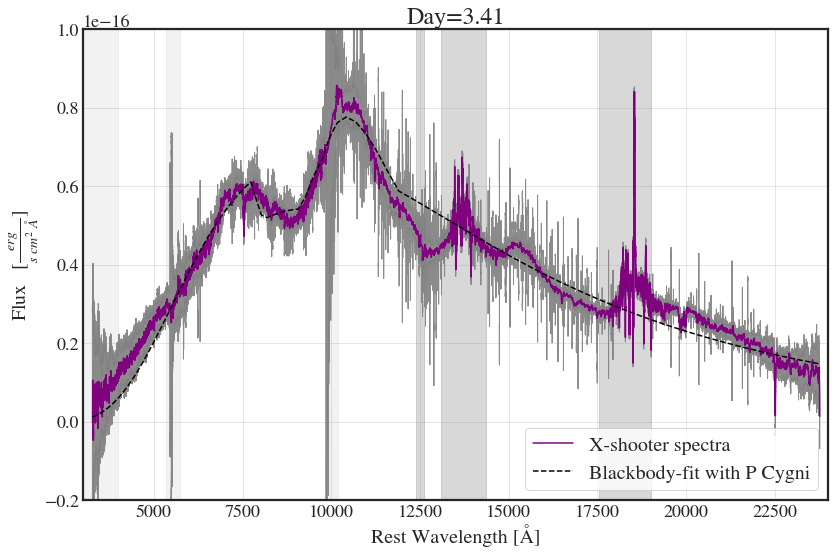

In [249]:
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(x[:,0], x[:,1], label='X-shooter spectra', color='purple')

plt.plot(x[:,0], planck_with_mod(x[:,0]*10**(-10),*p), ls='--', color='k', label='Blackbody-fit with P Cygni')
#plt.plot(x[:,0], planck_with_mod(x[:,0]*10**(-10),*(p3+[0,1e-30,0,0,0,0])), ls='--', color='k', label='Blackbody-fit with P Cygni')

plt.fill_between(x[:,0], x[:,1]-x[:,3], x[:,1]+x[:,3], 
                 color='grey', alpha=0.9)

plt.xlim(3000, 24000), plt.ylim(-2*10**(-17),10**(-16))
plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')

#define telluric region
ax.fill_between([12400, 12600], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([13100, 14360], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

psig = np.sqrt(np.diagonal(cov))
plt.legend(frameon=True)
plt.tight_layout(), plt.title('Day=3.41')
#plt.savefig('P-cygni-day3-2.png', dpi=300)

d3,dd3 = lum_dist([p[0],p[1]], [psig[0],psig[1]*50],p[3],psig[3],n_days=3.41)

In [252]:
p

array([3.10806791e+03, 1.80195191e-29, 2.63973626e-01, 2.30734684e-01,
       2.83006821e+00, 2.08564744e+00])

In [248]:
lum_dist([p[0],p[1]], [psig[0],psig[1]*50],p[3],psig[3],n_days=3.41)

(43.63428163587782, 1.0718596567265744)

In [229]:
n_days

[1.43, 2.42, 3.41, 4.4]

In [158]:
298800/3600/24, 126000/3600/24

(3.4583333333333335, 1.4583333333333333)

In [474]:
#### Day 4

In [219]:
x = np.loadtxt(path+'/'+files[3])
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14360))) & (~((x[:,0] > 17550) & (x[:,0] < 19000))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (x[:,0] > 3400) & (x[:,0] < 22500)


In [220]:
p, cov = curve_fit(planck_with_mod, x[:,0][exc_reg_2]*10**(-10), x[:,1][exc_reg_2], 
    sigma = x[:,3][exc_reg_2], p0 = [3000, 2*10**(-29),0.27,0.18,1,2.5], absolute_sigma=True)
#3.02071259e+03, 1.92140542e-29
p4 = p
p4_sig = np.sqrt(np.diagonal(cov))

C:\Users\asnep\Downloads\Kilonova\pcygni_profile.py:489: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, mode))[0]


C:\Users\asnep\Downloads\Kilonova\pcygni_profile.py:489: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, mode))[0]


40.25009171817643 0.023662084337444197


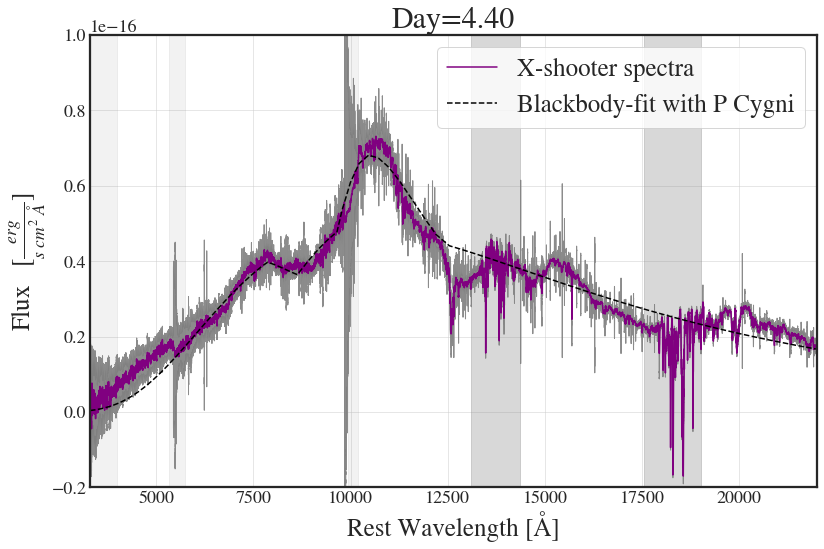

In [38]:
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(x[:,0], x[:,1], label='X-shooter spectra', color='purple')

plt.plot(x[:,0], planck_with_mod(x[:,0]*10**(-10),*p), ls='--', color='k', label='Blackbody-fit with P Cygni')
plt.fill_between(x[:,0], x[:,1]-x[:,3], x[:,1]+x[:,3], 
                 color='grey', alpha=0.9)

plt.xlim(3300, 22000), plt.ylim(-2*10**(-17),10**(-16))
plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')

#define telluric region
ax.fill_between([13100, 14360], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.legend(frameon=True)
plt.tight_layout(), plt.title('Day=4.40')
#plt.savefig('P-cygni-day4.png', dpi=300)

psig = np.sqrt(np.diagonal(cov))
d4,dd4 = lum_dist([p[0],p[1]], [psig[0],psig[1]],p[3],psig[3],n_days=n_days[3])
print(d4,dd4)

In [39]:
d4, dd4

(40.25009171817643, 0.023662084337444197)

In [482]:
#### Day 2

In [42]:
x = np.loadtxt(path+'/'+files[1])
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14360))) & (~((x[:,0] > 17550) & (x[:,0] < 19000))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (x[:,0] > 3400) & (x[:,0] < 22500)

p, cov = curve_fit(planck_with_mod, x[:,0][exc_reg_2]*10**(-10), x[:,1][exc_reg_2], 
    sigma = x[:,3][exc_reg_2], p0 = [3000, 2*10**(-29),0.3,0.25,1,2], absolute_sigma=True)
#3.02071259e+03, 1.92140542e-29

p2 = p
p2_sig = np.sqrt(np.diagonal(cov))

C:\Users\asnep\Downloads\Kilonova\pcygni_profile.py:489: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, mode))[0]


C:\Users\asnep\Downloads\Kilonova\pcygni_profile.py:489: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, mode))[0]


39.49027024244099 0.0379648992170539


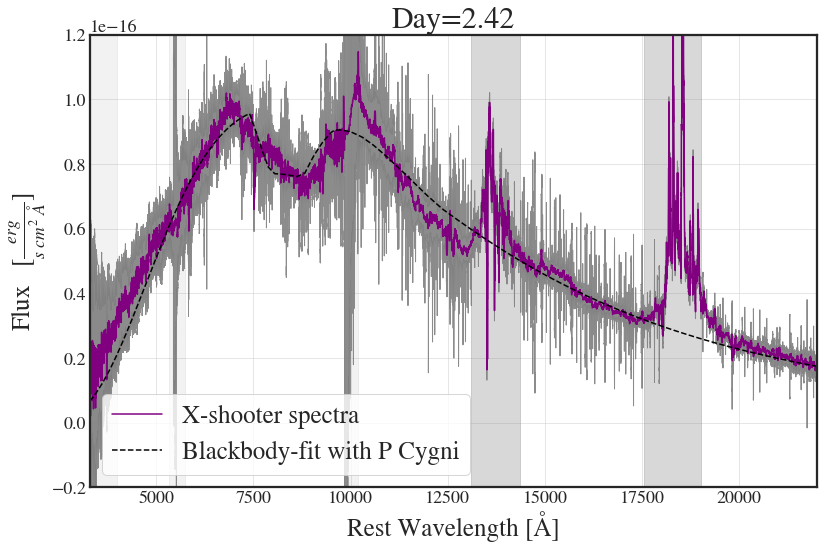

In [43]:
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(x[:,0], x[:,1], label='X-shooter spectra', color='purple')

plt.plot(x[:,0], planck_with_mod(x[:,0]*10**(-10),*p), ls='--', color='k', label='Blackbody-fit with P Cygni')
plt.fill_between(x[:,0], x[:,1]-x[:,3], x[:,1]+x[:,3], 
                 color='grey', alpha=0.9)

plt.xlim(3300, 22000), plt.ylim(-2*10**(-17),1.2*10**(-16))
plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')

#define telluric region
ax.fill_between([13100, 14360], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.legend(frameon=True)
plt.tight_layout(), plt.title('Day=2.42')
#plt.savefig('P-cygni-day2.png', dpi=300)

psig = np.sqrt(np.diagonal(cov))
d2,dd2 = lum_dist([p[0],p[1]], [psig[0],psig[1]],p[3],psig[3],n_days=n_days[1])
print(d2, dd2)

In [44]:
p

array([3.61545975e+03, 1.22794208e-29, 2.94369641e-01, 2.43203728e-01,
       1.43909979e+00, 5.04132159e-01])

In [416]:
### Day 1

(40.69333219398393, 0.02914418260192633)

In [52]:
x = np.loadtxt(path+'/'+files[0])
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14360))) & (~((x[:,0] > 17550) & (x[:,0] < 19000))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (x[:,0] > 4000) & (x[:,0] < 22500)

p, cov = curve_fit(planck_with_mod, x[:,0][exc_reg_2]*10**(-10), x[:,1][exc_reg_2], 
    sigma = x[:,3][exc_reg_2], p0 = [5000, 2*10**(-29),0.32,0.27,1,1, 0.], absolute_sigma=True)
#3.02071259e+03, 1.92140542e-29

p1 = p
p1_sig = np.sqrt(np.diagonal(cov))

C:\Users\asnep\Downloads\Kilonova\pcygni_profile.py:489: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, mode))[0]


In [53]:
chi = (x[:,1]-planck_with_mod(x[:,0]*10**(-10),*p))**2/(x[:,3])**2
print(np.sum(chi[exc_reg_2]), len(chi[exc_reg_2]), np.sum(chi[exc_reg_2])/len(chi[exc_reg_2]) )

263413.5462093124 41679 6.3200543729291105


C:\Users\asnep\Downloads\Kilonova\pcygni_profile.py:489: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, mode))[0]


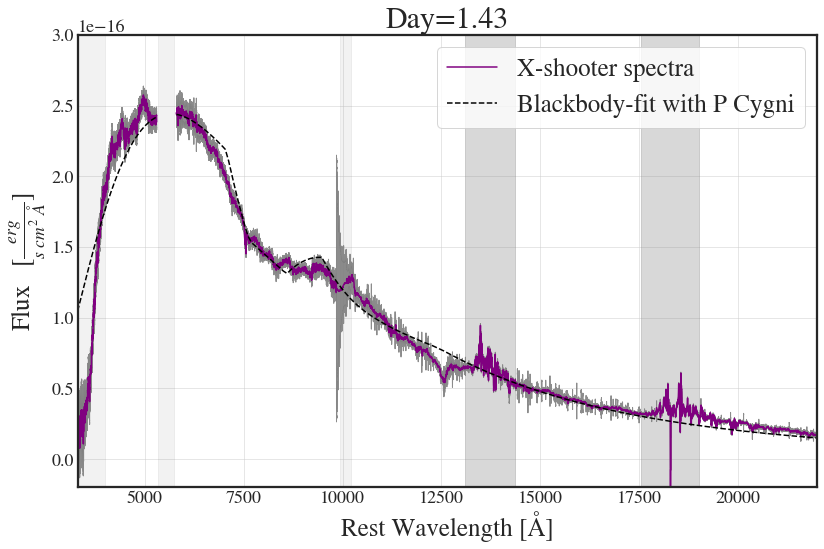

In [54]:
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(x[:,0], x[:,1], label='X-shooter spectra', color='purple')

plt.plot(x[:,0], planck_with_mod(x[:,0]*10**(-10),*p), ls='--', color='k', label='Blackbody-fit with P Cygni')
plt.fill_between(x[:,0], x[:,1]-x[:,3], x[:,1]+x[:,3], 
                 color='grey', alpha=0.9)

plt.xlim(3300, 22000), plt.ylim(-2*10**(-17),3*10**(-16))
plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')

#define telluric region
ax.fill_between([13100, 14360], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.legend(frameon=True)
plt.tight_layout(), plt.title('Day=1.43')
#plt.savefig('P-cygni-day1.png', dpi=300)

psig = np.sqrt(np.diagonal(cov))
d1,dd1 = lum_dist([p[0],p[1]], [psig[0],psig[1]],p[3],psig[3],n_days=n_days[0])

distance_modulus = 39.84175893313189 pm 0.22117535052860837


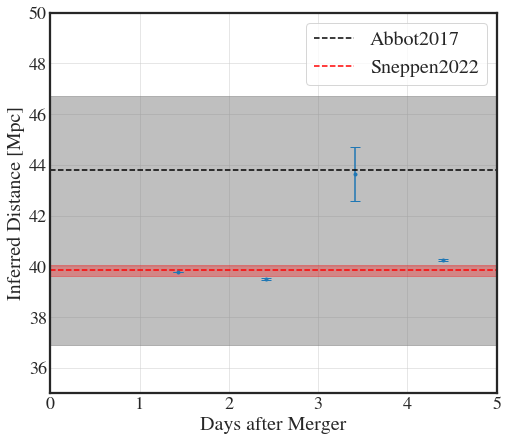

In [251]:
plt.figure(figsize=(8,7))
plt.errorbar( [1.43, 2.42, 3.41, 4.40], [d1,d2,d3,d4], yerr = np.array([dd1,dd2,dd3,dd4]), 
             fmt='.', capsize=5 )
plt.xlabel('Days after Merger'), plt.ylabel('Inferred Distance [Mpc]')

d_best = np.mean([d1,d2,d4])
ddbest = np.std([d1,d2,d4])/np.sqrt(2)
d_weight = np.sum( [d1,d2,d3,d4]*np.array([dd1,dd2,dd3,d4])**2/np.sum(np.array([dd1,dd2,dd3,d4])**2) )

print('distance_modulus =', d_best,'pm', ddbest)
plt.axhline(43.8, ls='--', color='k', label='Abbot2017')
plt.fill_between(np.arange(0,6), (36.9)*np.ones(6), (46.7)*np.ones(6), 
                 color='grey', alpha = 0.5)


plt.ylim(35,50), plt.xlim(0,5), 
plt.axhline(d_best, ls='--', color='red', label='Sneppen2022')
plt.fill_between(np.arange(0,6), (d_best-ddbest)*np.ones(6), (d_best+ddbest)*np.ones(6), 
                 color='red', alpha = 0.3)

plt.legend(frameon=True)

#plt.axhline(0.00968*c*10**(-3)/H0_shoes, ls='--', alpha=0.4)
#plt.axhline(0.00968*c*10**(-3)/H0_planck, ls='--', color='red', alpha=0.4)

#plt.savefig('Pictures/27-12-2021-2.png', dpi=300)

In [216]:
0.0098*c*(10**(-3))/d_best

74.17201226305313

In [217]:
0.0098*c*(10**(-3))/d3

67.38917317320055

In [218]:
dH0 = ((0.0098*c*(10**(-3))/d_best**2*ddbest)**2 + (0.0005*c*(10**(-3))/d_best)**2 )**(1/2)
dH0

3.7893036480360793

In [639]:
np.log10( 0.05*c*10**(-2)*24*3600 )

10.112605001534574

In [635]:
3017/c, 166/c

(1.0056666666666666e-05, 5.533333333333334e-07)

In [134]:
n_days = [1.43, 2.42, 3.41, 4.40]
temp   = p1[0], p2[0], p3[0], p4[0]
v_max  = p1[2], p2[2], p3[2], p4[2]
v_phot = p1[3], p2[3], p3[3], p4[3]
tau = p1[4], p2[4], 0.55, 0.55 #p3[4], p4[4]
lam    = p1[5], 10550, 10550, 10550

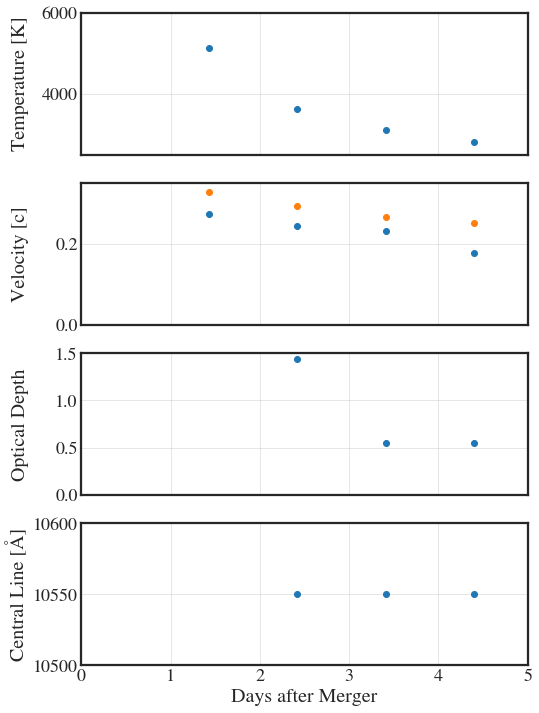

In [207]:
reset_plt(18,20)

fig,ax = plt.subplots( figsize=(8,12), nrows=4, ncols=1, sharex=True )
ax = ax.flatten(); plt.xlim(0,5), plt.xlabel('Days after Merger')
ax[0].scatter(n_days, temp),   ax[0].set_ylabel('Temperature [K]'), ax[0].set_ylim(2500,6000)
ax[1].scatter(n_days, v_phot), ax[1].set_ylabel('Velocity [c]')   , ax[1].set_ylim(0,0.35)
ax[1].scatter(n_days, v_max)

ax[2].scatter(n_days, tau),    ax[2].set_ylabel('Optical Depth'), ax[2].set_ylim(0,1.5)
ax[3].scatter(n_days, lam),    plt.ylabel('Central Line [Å]'), ax[3].set_ylim(10500, 10600)
plt.axhline(10300, ls='--', color='k'),plt.axhline(10900, ls='--', color='k'), 
plt.axhline(10030, ls='--', color='k')


ax[0].ticklabel_format(axis='y', style='plain')
ax[1].ticklabel_format(axis='y', style='plain')
ax[2].ticklabel_format(axis='y', style='plain')
ax[3].ticklabel_format(axis='y', style='plain')

fig.align_ylabels(ax)

#plt.savefig('Parameters_time.png', dpi=300)

In [595]:
tau

(0.5517054301306143, 0.6188192608858581, 2.246921141639292, 0.185405920876153)

In [650]:
temp

(5172.2579774778, 3613.6653693763324, 3097.4270529550085, 2837.946451046289)